In [88]:
import quandl
podatci = quandl.get("LME/PR_CO", authtoken="Bygw8KP9XWpisC6gGapq") #cijene kobalta
podatci.columns

Index(['Cash Buyer', 'Cash Seller & Settlement', '3-months Buyer',
       '3-months Seller', '15-months Buyer', '15-months Seller'],
      dtype='object')

promatrati ćemo stupac Cash Buyer te ćemo ogledati kako razlićiti regresijski modeli opisuju kretanje cijena kobalta

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

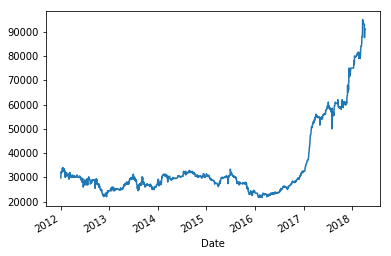

In [100]:
cijena = podatci["Cash Buyer"].as_matrix(columns= None)  #y vrijednosti

podatci["Cash Buyer"].plot()

odmah vidimo da regresija pravcem nece dobro opisivati podatke jer je cijena skoro stalno rasla od 2017 godine. Ali svejedno ćemo napraviti i regresiju pravcem jer ćemo je uspoređivati kasnije sa drugima

In [101]:
X = np.c_[np.ones(len(cijena)) , range(len(cijena)) ]
initTheta = np.array([0,0])

za računanje koeficjenata našeg modela trebati će nam dvije funkcije, jedna koja će računati koliko naš model dobro opisuje podatke koristeći sumu kvadratnog odstupanja, a druga će biti funkcija koja će gradijentnim spustom izračunati optimalnu vrijednost našeg parametra

In [102]:
def LinRegComputeCost(X ,y ,theta ):
    m = len(y)
    h = np.dot(X, theta)
    J = (1/(2*m)) * np.sum(np.power(h-y,2))
    return J

In [110]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_povijest = np.zeros(num_iters)
    for i in range(0, num_iters):
        h = np.dot(X,theta)
        grad = np.dot(X.transpose(), h-y)/m
        theta = theta - alpha*grad
        J_povijest[i] = LinRegComputeCost(X ,y ,theta)
    return theta, J_povijest   

In [104]:
def particioniranje(X,y):
    m = X.shape[1]
    Xy = np.c_[X , y]
    Xyperm = np.random.permutation(Xy)
    X_train = Xyperm[ :int(0.7*len(X)), :m ]  #prvih 70%
    X_test = Xyperm[ int(0.7*len(X)):, :m ]
    y_train = np.multiply(Xyperm[ :int(0.7*len(X)), m ], 0.001)   # cijena u 1000 $
    y_test = np.multiply(Xyperm[ int(0.7*len(X)):, m ], 0.001)
    return X_train, X_test, y_train, y_test

In [111]:
br_iteracija = 1500
alpha = 0.01
X_train = X[ :int(0.7*len(X)), : ]  #prvih 70%
X_test = X[int(0.7*len(X)):, : ]
y_train = np.multiply(cijena[ :int(0.7*len(cijena))], 0.001)   # cijena u 1000 $
y_test = np.multiply(cijena[ int(0.7*len(cijena)): ], 0.001)
optimal_theta, J_history = gradientDescent(X_train, y_train, initTheta, 0.0000006, br_iteracija)
optimal_theta, J_history[-1]

(array([0.00660624, 0.03776969]), 109.80853281449383)

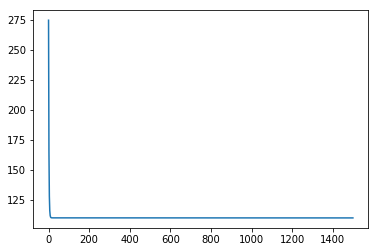

In [106]:
plt.plot(J_history)
plt.show()

vidimo da smo gradijentnim spustom našli približno optimalno rješenje

In [85]:
fig1, ax1 = plt.subplots()
ax1.plot(X[:,1], np.matmul(X,optimal_theta))
ax1.plot(X[:,1], cijena*0.001)

pametnije particioniranje skupa podataka je da ne uzimamo prvih 70% i zadnjih 30% nego kroz random permutacije

In [81]:
X2_train, X2_test, y2_train, y2_test = particioniranje(X, cijena)
optimal_theta2, J_history2 = gradientDescent(X2_train, y2_train, initTheta, 0.0000006, br_iteracija)
optimal_theta2, J_history2[-1]

(array([0.00413952, 0.03826501]), 111.32909812371304)

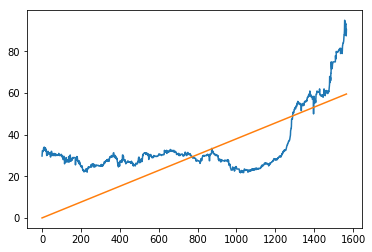

In [161]:
fig2, ax2 = plt.subplots()
ax2.plot(X[:,1], cijena*0.001)
ax2.plot(X[:,1], np.dot(X,optimal_theta2))

In [162]:
LinRegComputeCost(X,cijena*0.001,optimal_theta) - LinRegComputeCost(X,cijena*0.001,optimal_theta2) 

0.03140159624231842

razlika je praktički neprimjetna, no razlog tome je najviše to što dani podatci nisu prikladni za regresiju pravcem. zato nastavljamo sa polinomijalnom regresijom 

In [163]:
tempsqr = np.power(range(len(cijena)),2)
Xsqr = np.c_[X , tempsqr]
initTheta= np.array([0,0,0])
Xsqr_train, Xsqr_test, y_train, y_test = particioniranje(Xsqr, cijena)
optimal_theta3, J_history3 = gradientDescent(Xsqr_train, y_train, initTheta, 0.000000000001, br_iteracija)
optimal_theta3

array([1.48854563e-08, 3.27959518e-06, 3.01051761e-05])

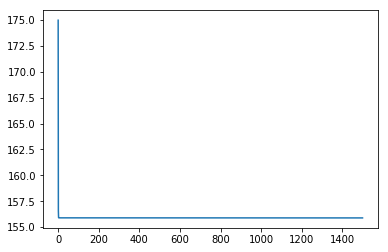

In [164]:
plt.plot(J_history3)    

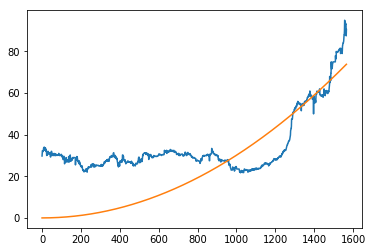

In [165]:
fig3, ax3 = plt.subplots()
ax3.plot(X[:,1], cijena*0.001)
ax3.plot(X[:,1], np.dot(Xsqr,optimal_theta3))

iako po grafu kretanja cijene funkcije izgleda kao da nas je gradijentni spust doveo priblizno blizu lokalnog optimuma, vidimo da naša krivulja ne opisuje dobro podatke kao što bi mogli očekivati. glavni razlog tome je jako mali arametar alpha kojeg smo morali koristiti, naime $alpha$ = 0.000000000001 kod gradijentnog spusta sto znaci da se naš algoritam spušta jako polako. idemo zato pogeldati plohu funkcije cijene u ovisnosti o parametru $theta$ 

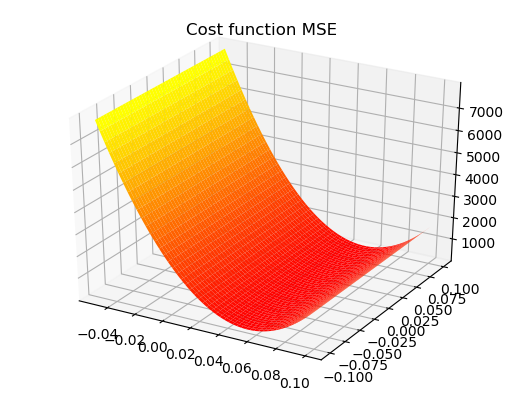

In [139]:
%matplotlib agg
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
thetax, thetay = np.meshgrid( np.linspace(-0.05,0.1,300), np.linspace(-0.1,0.1,300) ) #[:, np.newaxis]

cost = np.zeros((300,300))
for i in range(0,300):
    for j in range(0,300):
      cost[i,j] = LinRegComputeCost(X, np.multiply( cijena,0.001 ), np.array([thetax[0][i], thetay[j][0]])) 
  

ax.plot_surface(thetax, thetay, cost, cmap=cm.autumn, linewidth=1)
ax.set_title('Cost function MSE')
fig

vidimo da je naša vrijednost za parametar $theta$ = (0.00413952, 0.03826501) koju smo našli gradijentnim skupom stvarno dobra aproksimacija lokalnog optimuma, samo što su podatci takvi da mala promjena u velicini parametara uvelike utječe na rast cijene, razlog tome je naravno veliki broj mjerenja. 